<a href="https://colab.research.google.com/github/oksusudom/Python_Learning/blob/main/AI_10_%EC%9D%B4%EC%88%98%EC%B2%A0_Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Section2 Project#


##데이터 선정 이유 및 문제 정의
---


####데이터 선정 이유####
- 금융권, 은행 및 신용카드사 App을 사용하다보면 고객의 금융정보 및 개인정보 분석에 따라 맞춤형 상품 추천 알고리즘을 많이 볼 수 있다. 
- 고객의 금융정보 및 개인정보를 통해 다양한 예측이 가능하겠지만 비교적 간단한 이진 분류 모델을 만들어 보고자 해당 데이터를 선정했다.

####문제 정의####
- 이 데이터를 통해 은행 기존 고객 중 recommended credit card 판매 제안을 수락할 가능성이 있는 고객을 예측하는 이진 분류 모델로 접근하려고 한다.  



## 가설 및 평가지표, Baseline 설정


---



평가지표
-   Target 특성은 'Is_Lead'로 설정되어 있는 dataset이다.
-   Train Dataset에서 'Is_Lead'가 '1'인 (판매 제안을 수락할 가능성이 있는)고객의 데이터를 통해, Test Dataset의 고객 데이터에서 'Is_Lead'를 예측한다.
-   해당 데이터는 imbalanced class를 가지고 있기 때문에 f1 score나 roc-auc curve를 평가지표로 사용한다.

가설 세우기
-   Age가 30 이상인 고객이 발급받을 가능성이 높다.
-   Vintage가 높은 고객이 카드를 발급받을 가능성이 높다.
-   Credit_Product를 이용하는 고객이 카드를 발급받을 가능성이 높다.
-   Avg_Account_Balance가 적은 고객이 카드를 발급받을 가능성이 높다.
-   3개월 이내 은행 서비스를 이용한 고객(Is_Active)이 카드를 발급받을 가능성이 높다.

Baseline 설정
-   이진 분류 문제이기 때문에 Target의 최빈값을 기준 모델로 세운다.



---

## EDA, PREPROCESSING

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pdpbox
!pip install shap
!pip install category_encoders
!pip install -U pandas-profiling
!pip install eli5
!pip install xgboost
!pip install catboost

In [ ]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# dataset load

df = pd.read_csv('/content/drive/MyDrive/URCLASS/Section2_Project/credit card/train.csv')

---
Dataset Detail






*   ID : Unique Identifier for a row
*   Gender : Gender of the Customer
*   Age : Age of the Customer (in Years)
*   Region_Code : Code of the Region for the customers
*   Occupation : Occupation Type for the customer
*   Channel_Code : Acquisition Channel Code for the Customer (Encoded)
*   Vintage : Vintage for the Customer (In Months)
*   Credit_Product : If the Customer has any active credit product (Home loan, Personal loan, Credit Card etc.)
*   Avg_Account_Balance : Average Account Balance for the Customer in last 12 Months
*   Is_Active : If the Customer is Active in last 3 Months
*   Is_Lead : If the Customer is interested for the Credit Card [0 : Customer is not interested], [1 : Customer is interested]

---

In [ ]:
df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [ ]:
# 중복 확인 : 중복 없음
#df.duplicated().value_counts()

In [ ]:
# 결측치 확인
df.isna().sum()

# Credit_Product 에 많은 결측치가 있는 것을 확인.

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [ ]:
# Credit_Product 결측치 확인
df.loc[df['Credit_Product'].isna()]

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
6,ETQCZFEJ,Male,62,RG282,Other,X3,20,NaN,1056750,Yes,1
15,UJ2NJKKL,Male,33,RG268,Self_Employed,X2,69,NaN,517063,Yes,1
31,ABPMK4WU,Female,32,RG279,Salaried,X4,15,NaN,1072850,Yes,1
36,MTEIXMB9,Female,41,RG268,Self_Employed,X3,62,NaN,962383,No,1
40,6WX9JDVK,Female,63,RG254,Other,X3,103,NaN,1249319,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...
245684,WVJFPREY,Female,51,RG281,Entrepreneur,X3,99,NaN,552992,No,1
245694,WIZBXYQZ,Female,50,RG277,Self_Employed,X2,92,NaN,1385124,No,1
245699,MARTXU7T,Male,53,RG254,Other,X2,19,NaN,1141825,Yes,1
245714,KSCFGXV3,Female,46,RG268,Self_Employed,X2,19,NaN,993195,No,1


In [ ]:
# 130862 행은 5개의 특성이 결측치이므로 삭제.
df = df.drop(130862)
df

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0
...,...,...,...,...,...,...,...,...,...,...,...
245720,BPAWWXZN,Male,51,RG284,Self_Employed,X3,109,NaN,1925586,No,0
245721,HFNB7JY8,Male,27,RG268,Salaried,X1,15,No,862952,Yes,0
245722,GEHAUCWT,Female,26,RG281,Salaried,X1,13,No,670659,No,0
245723,GE7V8SAH,Female,28,RG273,Salaried,X1,31,No,407504,No,0


In [ ]:
import pandas_profiling
profiling_report = df.profile_report()

profiling_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

*   df 의 Credit_Product 특성의 결측치가 10% 이상이다.
*   Credit_Product 특성이 다른 특성에 영향을 주는지 확인 후 처리

### Target 확인

In [ ]:
df['Is_Lead'].value_counts(normalize=True)

0    0.762795
1    0.237205
Name: Is_Lead, dtype: float64

Target 최빈값 정확도 0.762795

In [ ]:
# imbalanced class 가중치

ratio = 0.762795 / 0.237205

ratio

3.215762736873169

In [ ]:
# visualization options
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
rcParams['font.style'] = 'normal'
background = '#F8F8F8'#f5fffa'#'#efeeee'#
palette =  sns.color_palette('BrBG_r', 20)
sns.set_context('poster', font_scale=0.8)

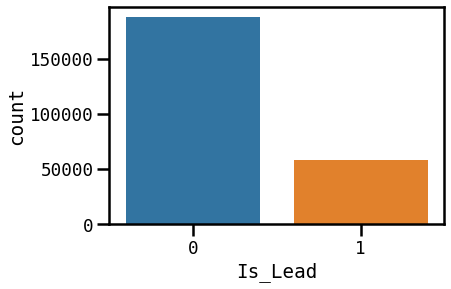

In [ ]:
sns.countplot(x = df['Is_Lead']);
plt.show() # imbalanced 확인



*   Target class가 불균형하기 때문에 f1 score나 roc_auc score로 모델의 성능 측정



##가설 검증

- Age가 30 이상인 고객이 발급받을 가능성이 높다.
- Vintage가 높은 고객이 카드를 발급받을 가능성이 높다.
- Credit_Product를 이용하는 고객이 카드를 발급받을 가능성이 높다.
- Avg_Account_Balance가 적은 고객이 카드를 발급받을 가능성이 높다.
- 3개월 이내 은행 서비스를 이용한 고객(Is_Active)이 카드를 발급받을 가능성이 높다.

가설 1. Age가 30 이상인 고객이 발급받을 가능성이 높다.

In [ ]:
# 전체 고객 중 판매 제안을 수락할 가능성이 있는 고객 58,297명
target_customers = df[df['Is_Lead'] == 1]
target_customers

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
6,ETQCZFEJ,Male,62,RG282,Other,X3,20,NaN,1056750,Yes,1
15,UJ2NJKKL,Male,33,RG268,Self_Employed,X2,69,NaN,517063,Yes,1
16,CNGSPYWS,Female,46,RG268,Other,X3,97,Yes,2282502,No,1
17,VH7NBNNQ,Female,59,RG283,Other,X3,15,Yes,2384692,No,1
20,7PMYNWB3,Male,44,RG269,Self_Employed,X2,19,Yes,1001650,No,1
...,...,...,...,...,...,...,...,...,...,...,...
245697,DTQJBXK6,Male,43,RG257,Salaried,X1,50,No,551203,Yes,1
245699,MARTXU7T,Male,53,RG254,Other,X2,19,NaN,1141825,Yes,1
245709,4GZKAUQC,Male,36,RG284,Self_Employed,X3,15,Yes,608110,Yes,1
245713,BZ7NHPMJ,Female,41,RG277,Self_Employed,X2,13,Yes,898170,Yes,1


In [ ]:
# 30세 이상 고객 중 판매 제안을 수락할 가능성이 있는 고객 54,291명
age_over_30 = df[(df['Age'] >= 30) & (df['Is_Lead'] == 1)]
age_over_30

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
6,ETQCZFEJ,Male,62,RG282,Other,X3,20,NaN,1056750,Yes,1
15,UJ2NJKKL,Male,33,RG268,Self_Employed,X2,69,NaN,517063,Yes,1
16,CNGSPYWS,Female,46,RG268,Other,X3,97,Yes,2282502,No,1
17,VH7NBNNQ,Female,59,RG283,Other,X3,15,Yes,2384692,No,1
20,7PMYNWB3,Male,44,RG269,Self_Employed,X2,19,Yes,1001650,No,1
...,...,...,...,...,...,...,...,...,...,...,...
245697,DTQJBXK6,Male,43,RG257,Salaried,X1,50,No,551203,Yes,1
245699,MARTXU7T,Male,53,RG254,Other,X2,19,NaN,1141825,Yes,1
245709,4GZKAUQC,Male,36,RG284,Self_Employed,X3,15,Yes,608110,Yes,1
245713,BZ7NHPMJ,Female,41,RG277,Self_Employed,X2,13,Yes,898170,Yes,1


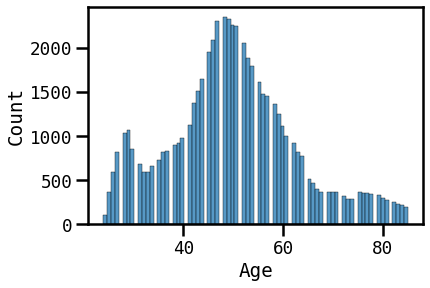

In [ ]:
sns.histplot(target_customers['Age']);



*   목표 고객(판매 제안을 수락할 가능성이 있는)의 대부분이 30세 이상이다.


가설 2. Vintage가 높은 고객이 카드를 발급받을 가능성이 높다.

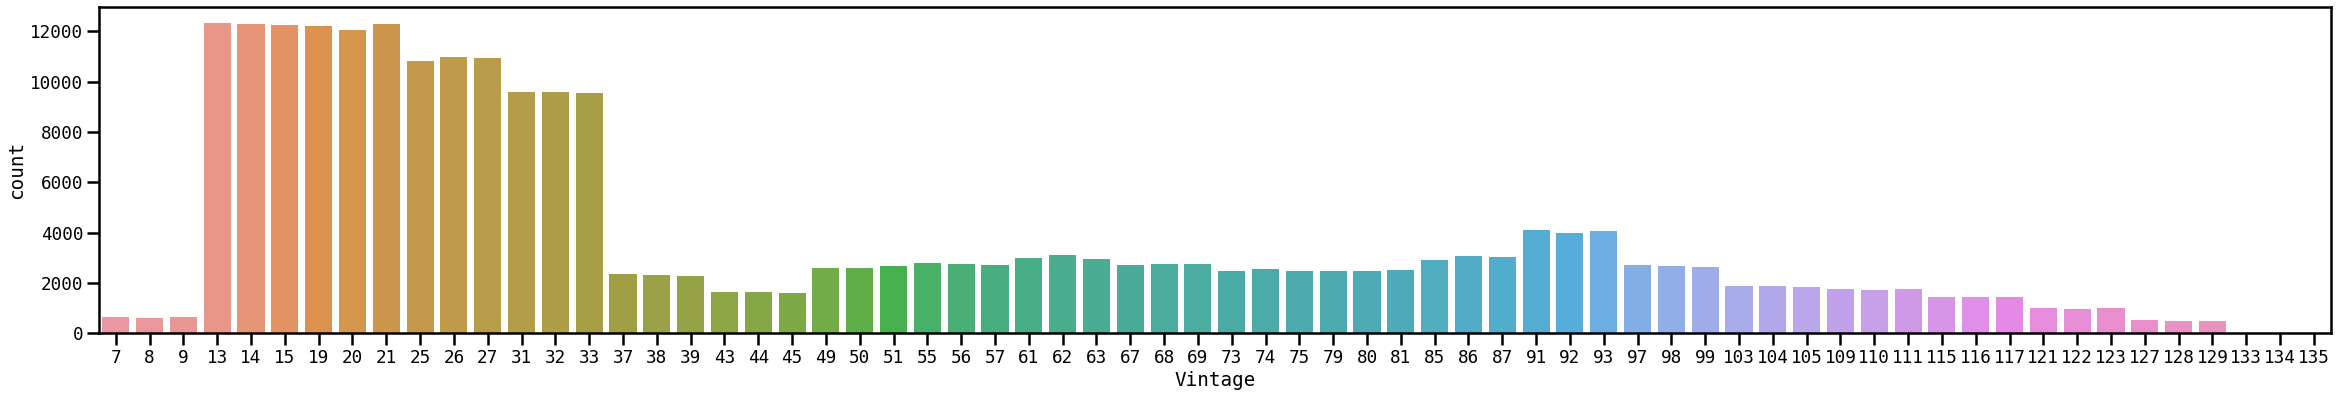

In [ ]:
# Vintage의 분포는 13 ~ 33이 가장 많음.
plt.figure(figsize = (40,6))
sns.countplot(x= df['Vintage']);

In [ ]:
# Vintage가 33 보다 큰 고객(3년 이상된 고객)이 목표 고객(판매 제안을 수락할 가능성이 있는)비중이 컸다.
vintage_over_3years = df[(df['Vintage'] > 33) & (df['Is_Lead'] == 1)]
vintage_over_3years

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
15,UJ2NJKKL,Male,33,RG268,Self_Employed,X2,69,NaN,517063,Yes,1
16,CNGSPYWS,Female,46,RG268,Other,X3,97,Yes,2282502,No,1
29,KGLLM5AM,Female,52,RG283,Self_Employed,X3,56,Yes,1056910,Yes,1
34,FXPTJYP7,Male,67,RG268,Other,X1,87,Yes,1684182,No,1
36,MTEIXMB9,Female,41,RG268,Self_Employed,X3,62,NaN,962383,No,1
...,...,...,...,...,...,...,...,...,...,...,...
245684,WVJFPREY,Female,51,RG281,Entrepreneur,X3,99,NaN,552992,No,1
245690,3HPHK52G,Male,51,RG283,Self_Employed,X1,91,No,766548,No,1
245693,NUTSCAQY,Female,52,RG273,Other,X3,74,Yes,1122023,Yes,1
245694,WIZBXYQZ,Female,50,RG277,Self_Employed,X2,92,NaN,1385124,No,1


In [ ]:
# Vintage가 33 작거나 같은 고객(3년 이하 고객)이 목표 고객(판매 제안을 수락할 가능성이 있는)비중이 적었다.
vintage_less_3years = df[(df['Vintage'] <= 33) & (df['Is_Lead'] == 1)]
vintage_less_3years

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
6,ETQCZFEJ,Male,62,RG282,Other,X3,20,NaN,1056750,Yes,1
17,VH7NBNNQ,Female,59,RG283,Other,X3,15,Yes,2384692,No,1
20,7PMYNWB3,Male,44,RG269,Self_Employed,X2,19,Yes,1001650,No,1
31,ABPMK4WU,Female,32,RG279,Salaried,X4,15,NaN,1072850,Yes,1
60,BHQ57HGE,Male,36,RG254,Self_Employed,X2,15,NaN,584792,No,1
...,...,...,...,...,...,...,...,...,...,...,...
245683,9VFKEFOS,Male,71,RG283,Other,X3,13,NaN,492873,No,1
245699,MARTXU7T,Male,53,RG254,Other,X2,19,NaN,1141825,Yes,1
245709,4GZKAUQC,Male,36,RG284,Self_Employed,X3,15,Yes,608110,Yes,1
245713,BZ7NHPMJ,Female,41,RG277,Self_Employed,X2,13,Yes,898170,Yes,1




*   Vintage가 높을 수록 목표 고객일 가능성이 높음.



가설3. Credit_Product를 이용하는 고객이 카드를 발급받을 가능성이 높다.

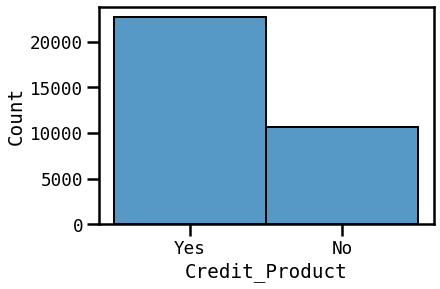

In [ ]:
sns.histplot(target_customers['Credit_Product']);

In [ ]:
# credit product를 이용하는 고객 중 목표 고객 22,690명
credit_product_use = df[(df['Credit_Product'] == 'Yes') & (df['Is_Lead'] == 1)]
credit_product_use

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
16,CNGSPYWS,Female,46,RG268,Other,X3,97,Yes,2282502,No,1
17,VH7NBNNQ,Female,59,RG283,Other,X3,15,Yes,2384692,No,1
20,7PMYNWB3,Male,44,RG269,Self_Employed,X2,19,Yes,1001650,No,1
29,KGLLM5AM,Female,52,RG283,Self_Employed,X3,56,Yes,1056910,Yes,1
34,FXPTJYP7,Male,67,RG268,Other,X1,87,Yes,1684182,No,1
...,...,...,...,...,...,...,...,...,...,...,...
245669,T7JQRU72,Female,26,RG259,Salaried,X1,20,Yes,501265,No,1
245670,FLW3ERJ4,Male,53,RG277,Self_Employed,X3,69,Yes,422705,Yes,1
245693,NUTSCAQY,Female,52,RG273,Other,X3,74,Yes,1122023,Yes,1
245709,4GZKAUQC,Male,36,RG284,Self_Employed,X3,15,Yes,608110,Yes,1


In [ ]:
# credit product를 이용하지 않는 고객 중 목표 고객인 고객 10,622명
credit_product_not_use = df[(df['Credit_Product'] == 'No') & (df['Is_Lead'] == 1)]
credit_product_not_use

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
126,QAGYQMYH,Female,52,RG283,Self_Employed,X2,56,No,861164,Yes,1
128,EMVN9YJW,Male,34,RG277,Salaried,X1,13,No,760229,Yes,1
150,KG875MV5,Male,26,RG254,Salaried,X1,26,No,1192333,Yes,1
185,GDZ5GWTZ,Male,42,RG254,Self_Employed,X2,91,No,816174,No,1
192,DBHGK8S8,Female,36,RG268,Salaried,X2,31,No,362292,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...
245628,DEXYZVQQ,Female,56,RG263,Self_Employed,X2,87,No,425197,Yes,1
245640,8VBLMAVS,Female,25,RG256,Salaried,X1,20,No,639910,Yes,1
245667,O7H4BRA4,Male,30,RG266,Salaried,X1,27,No,822457,Yes,1
245690,3HPHK52G,Male,51,RG283,Self_Employed,X1,91,No,766548,No,1


In [ ]:
# credit product가 결측치인 고객 중 목표 고객 24,975명
credit_product_NaN = df[(df['Credit_Product'].isna()) & (df['Is_Lead'] == 1)]
credit_product_NaN

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
6,ETQCZFEJ,Male,62,RG282,Other,X3,20,NaN,1056750,Yes,1
15,UJ2NJKKL,Male,33,RG268,Self_Employed,X2,69,NaN,517063,Yes,1
31,ABPMK4WU,Female,32,RG279,Salaried,X4,15,NaN,1072850,Yes,1
36,MTEIXMB9,Female,41,RG268,Self_Employed,X3,62,NaN,962383,No,1
40,6WX9JDVK,Female,63,RG254,Other,X3,103,NaN,1249319,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...
245683,9VFKEFOS,Male,71,RG283,Other,X3,13,NaN,492873,No,1
245684,WVJFPREY,Female,51,RG281,Entrepreneur,X3,99,NaN,552992,No,1
245694,WIZBXYQZ,Female,50,RG277,Self_Employed,X2,92,NaN,1385124,No,1
245699,MARTXU7T,Male,53,RG254,Other,X2,19,NaN,1141825,Yes,1




*   credit product를 이용하는 고객이 목표 고객일 가능성이 높으나, 결측치가 많아 단정할 수 없음.



가설4. Avg_Account_Balance가 적은 고객이 카드를 발급받을 가능성이 높다.

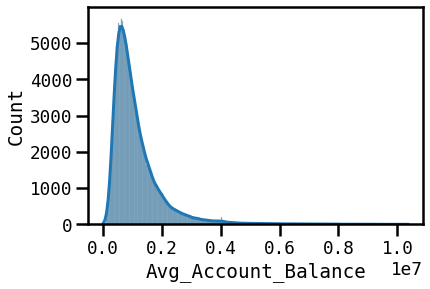

In [ ]:
# Avg_Account_Balance의 분포
sns.histplot(df['Avg_Account_Balance'], kde = True);

In [ ]:
# Avg_Account_Balance의 평균값
df['Avg_Account_Balance'].mean()

1128401.8569492602

In [ ]:
# Avg_Account_Balance의 평균값보다 낮은 고객은 목표 고객일 가능성이 조금 더 높음.
low_balance = df[(df['Avg_Account_Balance'] < 1128401) & (df['Is_Lead'] == 1)]
low_balance

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
6,ETQCZFEJ,Male,62,RG282,Other,X3,20,NaN,1056750,Yes,1
15,UJ2NJKKL,Male,33,RG268,Self_Employed,X2,69,NaN,517063,Yes,1
20,7PMYNWB3,Male,44,RG269,Self_Employed,X2,19,Yes,1001650,No,1
29,KGLLM5AM,Female,52,RG283,Self_Employed,X3,56,Yes,1056910,Yes,1
31,ABPMK4WU,Female,32,RG279,Salaried,X4,15,NaN,1072850,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...
245693,NUTSCAQY,Female,52,RG273,Other,X3,74,Yes,1122023,Yes,1
245697,DTQJBXK6,Male,43,RG257,Salaried,X1,50,No,551203,Yes,1
245709,4GZKAUQC,Male,36,RG284,Self_Employed,X3,15,Yes,608110,Yes,1
245713,BZ7NHPMJ,Female,41,RG277,Self_Employed,X2,13,Yes,898170,Yes,1


가설5. 3개월 이내 은행 서비스를 이용한 고객(Is_Active)이 카드를 발급받을 가능성이 높다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


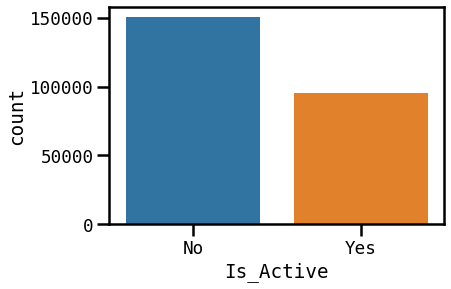

In [ ]:
# Is_Active의 분포
sns.countplot(df['Is_Active']);

In [ ]:
Active_customer = df[(df['Is_Active'] == 'Yes') & (df['Is_Lead'] == 1)]
Active_customer

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
6,ETQCZFEJ,Male,62,RG282,Other,X3,20,NaN,1056750,Yes,1
15,UJ2NJKKL,Male,33,RG268,Self_Employed,X2,69,NaN,517063,Yes,1
29,KGLLM5AM,Female,52,RG283,Self_Employed,X3,56,Yes,1056910,Yes,1
31,ABPMK4WU,Female,32,RG279,Salaried,X4,15,NaN,1072850,Yes,1
37,AGDXY8Y5,Male,59,RG284,Self_Employed,X3,55,Yes,294714,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...
245693,NUTSCAQY,Female,52,RG273,Other,X3,74,Yes,1122023,Yes,1
245697,DTQJBXK6,Male,43,RG257,Salaried,X1,50,No,551203,Yes,1
245699,MARTXU7T,Male,53,RG254,Other,X2,19,NaN,1141825,Yes,1
245709,4GZKAUQC,Male,36,RG284,Self_Employed,X3,15,Yes,608110,Yes,1


In [ ]:
InActive_customer = df[(df['Is_Active'] == 'No') & (df['Is_Lead'] == 1)]
InActive_customer

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
16,CNGSPYWS,Female,46,RG268,Other,X3,97,Yes,2282502,No,1
17,VH7NBNNQ,Female,59,RG283,Other,X3,15,Yes,2384692,No,1
20,7PMYNWB3,Male,44,RG269,Self_Employed,X2,19,Yes,1001650,No,1
34,FXPTJYP7,Male,67,RG268,Other,X1,87,Yes,1684182,No,1
36,MTEIXMB9,Female,41,RG268,Self_Employed,X3,62,NaN,962383,No,1
...,...,...,...,...,...,...,...,...,...,...,...
245683,9VFKEFOS,Male,71,RG283,Other,X3,13,NaN,492873,No,1
245684,WVJFPREY,Female,51,RG281,Entrepreneur,X3,99,NaN,552992,No,1
245690,3HPHK52G,Male,51,RG283,Self_Employed,X1,91,No,766548,No,1
245694,WIZBXYQZ,Female,50,RG277,Self_Employed,X2,92,NaN,1385124,No,1




*   3개월 이내 이용하지 않은 고객의 경우 목표 고객일 가능성이 조금 더 높았다.


직업별로 차이가 있는지 확인

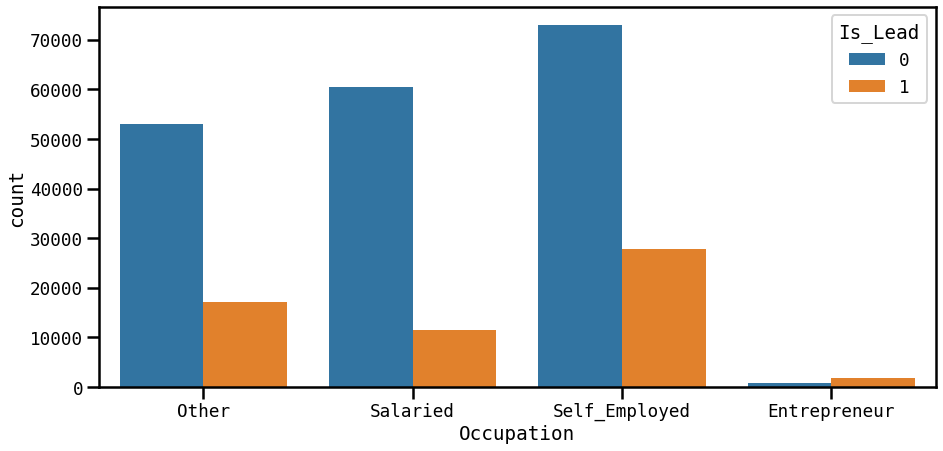

In [ ]:
plt.subplots(figsize= (15, 7))
sns.countplot(x = 'Occupation', hue='Is_Lead', data=df);

 

*   Entrepreneur(사업가)는 목표 고객 가능성이 높았다.
*   급여를 받는 사람은 목표 고객이 아닐 가능성이 높은 편이다.





---

Feature Engineering

In [ ]:
# 불필요한 ID column 제거
df = df.drop(['ID'], axis = 1)
df

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0
...,...,...,...,...,...,...,...,...,...,...
245720,Male,51,RG284,Self_Employed,X3,109,NaN,1925586,No,0
245721,Male,27,RG268,Salaried,X1,15,No,862952,Yes,0
245722,Female,26,RG281,Salaried,X1,13,No,670659,No,0
245723,Female,28,RG273,Salaried,X1,31,No,407504,No,0


##Train data와 Validation data로 나누기

In [ ]:
target = 'Is_Lead'

features = df.columns.drop([target])

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

train.shape, val.shape, test.shape

((157263, 10), (39316, 10), (49145, 10))

###Baseline### 

In [ ]:
# baseline
from sklearn.metrics import accuracy_score

major = y_train.mode()[0]
pred = [major] * len(y_train)
val_pred = [major] * len(y_val)

# target class의 최빈값이 정확도
print("training_accuracy_score: ", accuracy_score(y_train, pred))
print("validation_accuracy_score: ", accuracy_score(y_val, val_pred))

training_accuracy_score:  0.7622263342299206
validation_accuracy_score:  0.7659477057686438


#ML Model Test

## Linear

In [ ]:
# LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor

lr = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    LogisticRegression(random_state=42)
)

#tt = TransformedTargetRegressor(regressor=lr,func=np.log1p, inverse_func=np.expm1)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

print('train accuracy:', lr.score(X_train, y_train))
print('validation accuracy:', lr.score(X_val, y_val))
print('report',classification_report(y_val, y_pred))
print('roc_auc_score: ', roc_auc_score(y_val, y_pred))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


train accuracy: 0.7622263342299206
validation accuracy: 0.7659477057686438
report               precision    recall  f1-score   support

           0       0.77      1.00      0.87     30114
           1       0.00      0.00      0.00      9202

    accuracy                           0.77     39316
   macro avg       0.38      0.50      0.43     39316
weighted avg       0.59      0.77      0.66     39316

roc_auc_score:  0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




*   f1 score를 봤을 때 제대로 작동하지 않았다. 




In [ ]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42)
)

dt.fit(X_train, y_train)
y_pred_01 = dt.predict(X_val)

print('train accuracy:', dt.score(X_train, y_train))
print('validation accuracy:', dt.score(X_val, y_val))
print('report',classification_report(y_val, y_pred_01))
print('roc_auc_score: ', roc_auc_score(y_val, y_pred_01))

train accuracy: 1.0
validation accuracy: 0.7862193509003967
report               precision    recall  f1-score   support

           0       0.87      0.85      0.86     30114
           1       0.54      0.57      0.55      9202

    accuracy                           0.79     39316
   macro avg       0.70      0.71      0.71     39316
weighted avg       0.79      0.79      0.79     39316

roc_auc_score:  0.7108378403319289




*   과적합 발생



In [ ]:
# RandomForestCalssifier
from sklearn.ensemble import RandomForestClassifier

rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

rf.fit(X_train, y_train)
y_pred_02 = rf.predict(X_val)

print('train accuracy:', rf.score(X_train, y_train))
print('validation accuracy:', rf.score(X_val, y_val))
print('report',classification_report(y_val, y_pred_02))
print('roc_auc_score: ', roc_auc_score(y_val, y_pred_02))

train accuracy: 0.9999364122520873
validation accuracy: 0.8544104181503713
report               precision    recall  f1-score   support

           0       0.88      0.94      0.91     30114
           1       0.74      0.58      0.65      9202

    accuracy                           0.85     39316
   macro avg       0.81      0.76      0.78     39316
weighted avg       0.85      0.85      0.85     39316

roc_auc_score:  0.7581819528449286




*   과적합으로 보여진다.




In [ ]:
# XGBClassifier
from xgboost import XGBClassifier

xg = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_jobs=-1, random_state=42))

xg.fit(X_train, y_train)
y_pred_03 = xg.predict(X_val)

print('train accuracy:', xg.score(X_train, y_train))
print('validation accuracy:', xg.score(X_val, y_val))
print('report',classification_report(y_val, y_pred_03))
print('roc_auc_score: ', roc_auc_score(y_val, y_pred_03))

train accuracy: 0.8604694047550918
validation accuracy: 0.8631091667514498
report               precision    recall  f1-score   support

           0       0.87      0.96      0.92     30114
           1       0.82      0.53      0.64      9202

    accuracy                           0.86     39316
   macro avg       0.85      0.75      0.78     39316
weighted avg       0.86      0.86      0.85     39316

roc_auc_score:  0.7473335657617045





*   roc_auc_score 성능이 가장 좋은 XGB 하이퍼파라미터 조정 진행.




---

## 하이퍼파라미터 조정

###XGBClassifier

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(scale_pos_weight=ratio, random_state=42)
)

dist = {
    'simpleimputer__strategy': ['most_frequent', 'constant'],
    'xgbclassifier__n_estimators' : randint(100,300),
    'xgbclassifier__max_depth' : [3, 5, 7, 10],
}

clf = RandomizedSearchCV(
    pipe,
    param_distributions=dist,
    n_iter=5,
    cv=3,
    scoring ='f1',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('xgbclassifier',
                                              XGBClassifier(random_state=42,
                                                            scale_pos_weight=3.215762736873169))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'simpleimputer__strategy': ['most_frequent',
                                                                    'constant'],
                                        'xgbclassifier__max_depth': [3, 5, 7,
                                                                     10],
                                        'xgbclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f17287f6490>},
                   scor

In [ ]:
print('best_params: ', clf.best_params_)

best_params:  {'simpleimputer__strategy': 'most_frequent', 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 213}


In [ ]:
model = clf.best_estimator_

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

print('train accuracy:', model.score(X_train, y_train))
print('validation accuracy:', model.score(X_val, y_val))
print('Report:',classification_report(y_val, y_pred_val))
print('roc_auc_score: ', roc_auc_score(y_val, y_pred_val))

train accuracy: 0.8284593324558224
validation accuracy: 0.8224132668633635
Report:               precision    recall  f1-score   support

           0       0.92      0.84      0.88     30114
           1       0.59      0.78      0.67      9202

    accuracy                           0.82     39316
   macro avg       0.76      0.81      0.78     39316
weighted avg       0.85      0.82      0.83     39316

roc_auc_score:  0.8064582219241158


#Final TestSet

In [ ]:
y_pred = model.predict(X_test)

print('test accuracy:', model.score(X_test, y_test))
print('Report:',classification_report(y_test, y_pred))
print('roc_auc_score: ', roc_auc_score(y_test, y_pred))

test accuracy: 0.8215281310407977
Report:               precision    recall  f1-score   support

           0       0.92      0.84      0.88     37453
           1       0.60      0.77      0.67     11692

    accuracy                           0.82     49145
   macro avg       0.76      0.80      0.77     49145
weighted avg       0.84      0.82      0.83     49145

roc_auc_score:  0.8031940458543826





*   최종 모델은 여러 개의 결정 트리를 임의적으로 학습하는 앙상블의 부스팅 유형인 XGBoostclassifier로 결정했다. 
*   하이퍼파라미터 조정에 의해 점수가 어느정도 개선되었다.



##Feature Importance

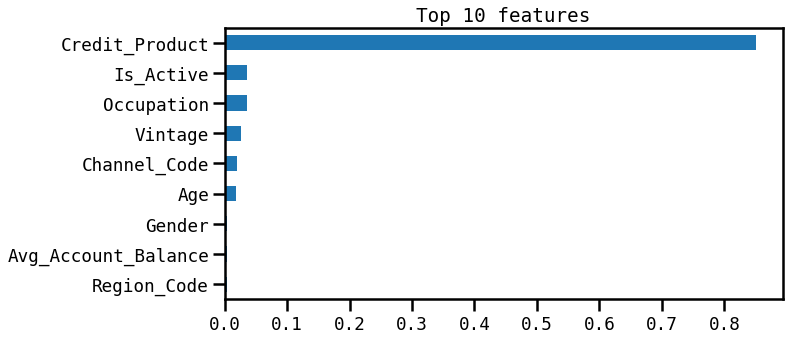

In [ ]:
xgb = model.named_steps['xgbclassifier']
importances = pd.Series(xgb.feature_importances_, X_train.columns)

import matplotlib.pyplot as plt
%matplotlib inline 

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [ ]:
from sklearn.pipeline import Pipeline
# encoder, imputer를 preprocessing으로 묶었습니다. 후에 eli5 permutation 계산에 사용합니다
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('xgb', XGBClassifier(n_estimators=213, random_state=42, n_jobs=-1)) 
])

In [ ]:
pipe.named_steps


{'preprocessing': Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                 ('simpleimputer', SimpleImputer())]),
 'xgb': XGBClassifier(n_estimators=213, n_jobs=-1, random_state=42)}

In [ ]:
pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.8630837318140198


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['xgb'], # model
    scoring='f1', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=42
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val);

In [ ]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Channel_Code          -0.000159
Gender                -0.000056
Region_Code           -0.000036
Avg_Account_Balance    0.000256
Is_Active              0.003933
Occupation             0.081174
Vintage                0.094532
Age                    0.146731
Credit_Product         0.364159
dtype: float64

In [ ]:
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.3642 ± 0.0055,Credit_Product
0.1467 ± 0.0016,Age
0.0945 ± 0.0022,Vintage
0.0812 ± 0.0042,Occupation
0.0039 ± 0.0021,Is_Active
0.0003 ± 0.0013,Avg_Account_Balance
-0.0000 ± 0.0007,Region_Code
-0.0001 ± 0.0003,Gender
-0.0002 ± 0.0007,Channel_Code


In [ ]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]

In [ ]:
# pipeline 다시 정의
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('xgb', RandomForestClassifier(n_estimators=213, random_state=42, n_jobs=-1)) 
], verbose=1)

pipe.fit(X_train_selected, y_train);

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing xgb, total=  21.5s


In [ ]:
print('검증 정확도: ', pipe.score(X_val_selected, y_val))

검증 정확도:  0.8473649404822464


#Interpreting ML Model

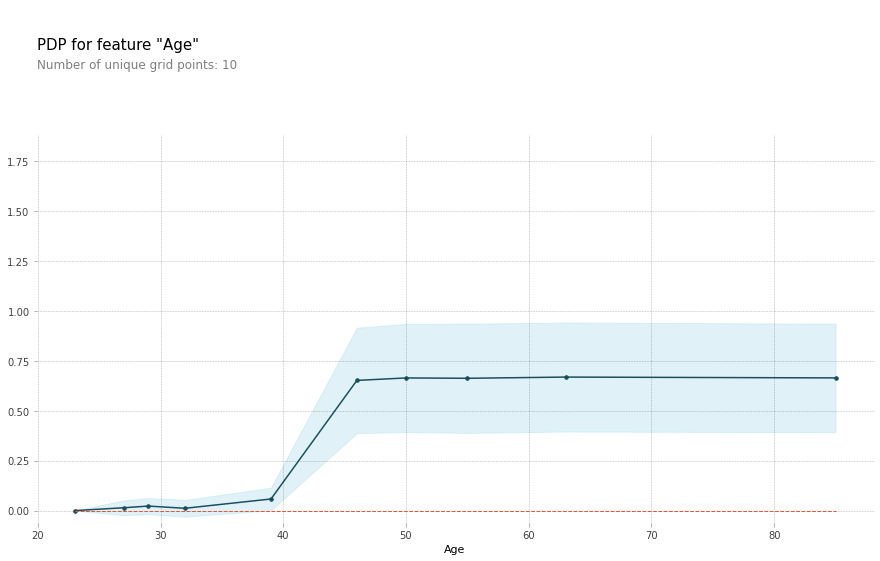

In [ ]:
encoder = OrdinalEncoder(handle_missing='value')
X_train_encoded = encoder.fit_transform(X_train)

from pdpbox import pdp
feature = 'Age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train_encoded, model_features=X_train_encoded.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature);



*   40세 이상부터는 영향도가 올라가지만 46세부터 더 많은 나이에서는 영향도가 일정해진다.



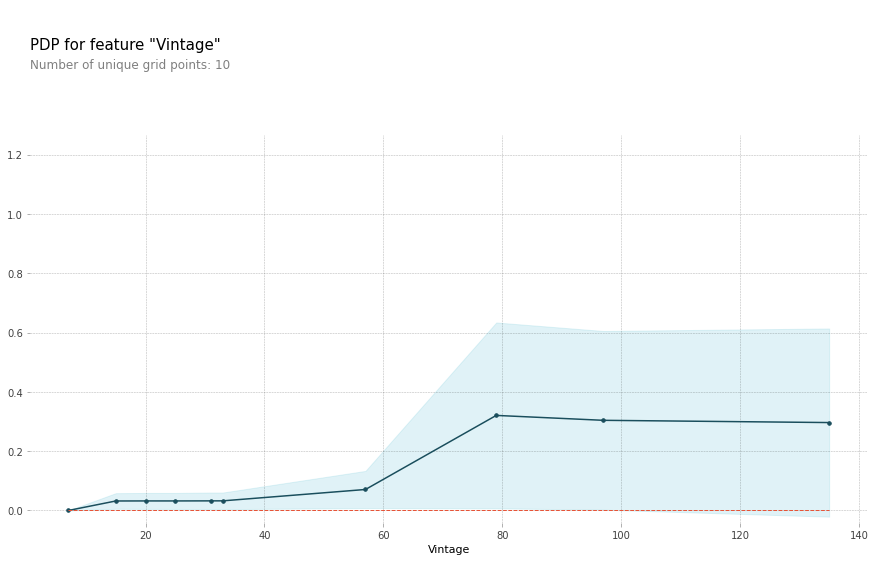

In [ ]:
feature = 'Vintage'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train_encoded, model_features=X_train_encoded.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature);



*   은행 서비스 이용기간(Vintage)가 40이 넘는 고객부터 서서히 영향도가 증가하다가 80에서 고점을 찍는다. 이후 소폭 하향하다가 일정해진다.
